In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
# Import necessary libraries

import pandas as pd
import numpy as np
import nltk
import re
import os
import json
import spacy
import nltk
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from spacy.lang.en import English
from sentence_transformers import SentenceTransformer, util
from spacy.lang.en.stop_words import STOP_WORDS

In [5]:
# Download necessary NLTK resources for text processing
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Load the Excel file
data_path = '/content/drive/MyDrive/scholarlink_nlp/university_data.xlsx'

# Load the data for students and professors
students_df = pd.read_excel(data_path, sheet_name='Students')
professors_df = pd.read_excel(data_path, sheet_name='Professors')

In [7]:
# Normalize and trim text data to ensure consistency
students_df = students_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
professors_df = professors_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

# Handle missing data by filling missing values with 'unknown'
students_df.fillna('unknown', inplace=True)
professors_df.fillna('unknown', inplace=True)

# Convert the 'Research Interests' column into lists for easier manipulation
students_df['Research Interests'] = students_df['Research Interests'].apply(lambda x: x.split(', '))
professors_df['Research Interests'] = professors_df['Research Interests'].apply(lambda x: x.split(', '))


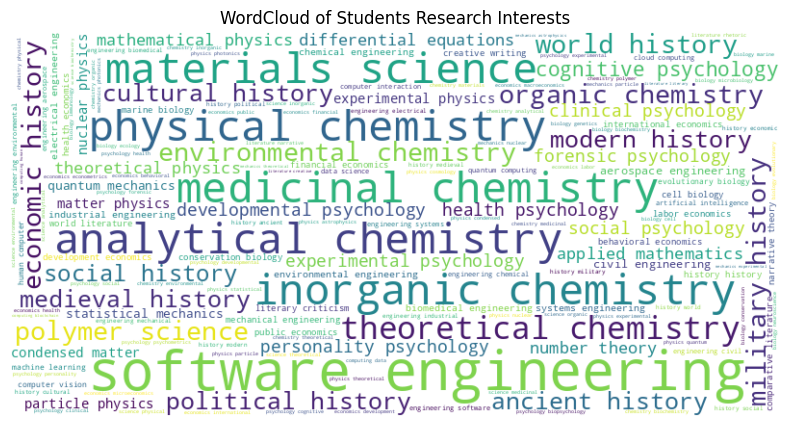

In [8]:
# WordCloud for Students' Research Interests
all_students_interests = ' '.join([interest for sublist in students_df['Research Interests'] for interest in sublist])
wordcloud_students = WordCloud(width = 800, height = 400, background_color ='white').generate(all_students_interests)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_students, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud of Students Research Interests')
plt.show()

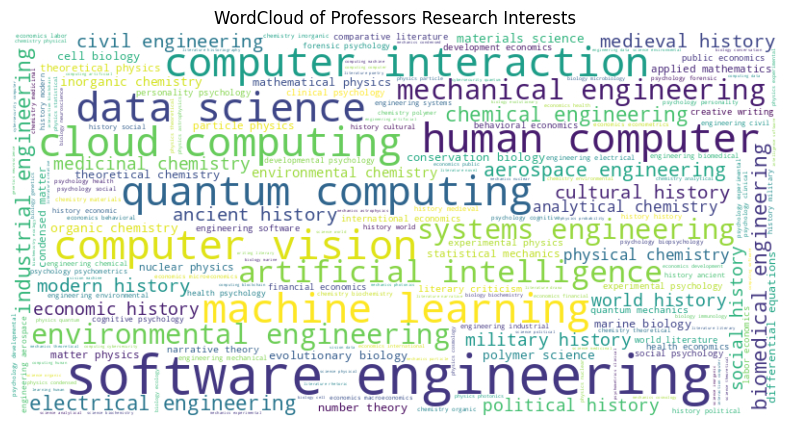

In [9]:
# WordCloud for Professors' Research Interests
all_professors_interests = ' '.join([interest for sublist in professors_df['Research Interests'] for interest in sublist])
wordcloud_professors = WordCloud(width = 800, height = 400, background_color ='white').generate(all_professors_interests)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_professors, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud of Professors Research Interests')
plt.show()

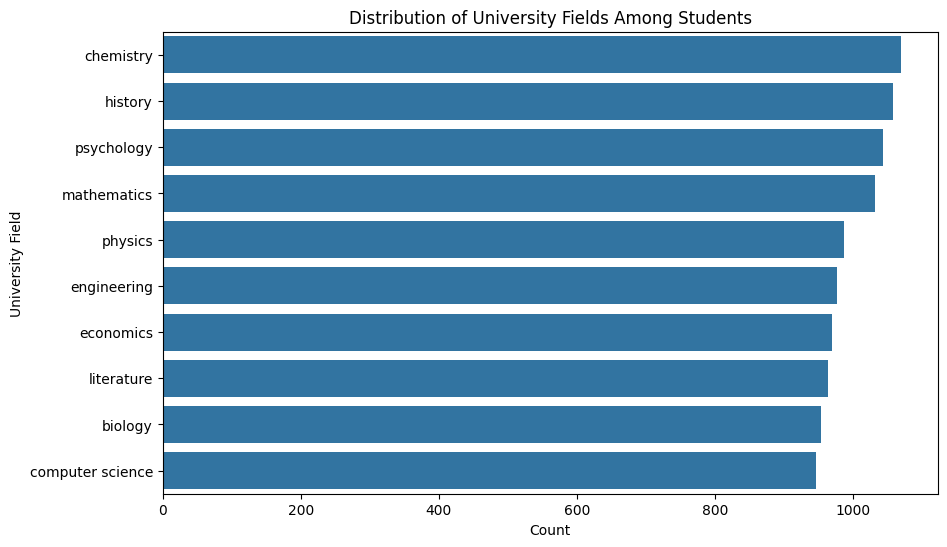

In [10]:
# Distribution of University Field for Students
plt.figure(figsize=(10, 6))
sns.countplot(y=students_df['University Field'], order = students_df['University Field'].value_counts().index)
plt.title('Distribution of University Fields Among Students')
plt.xlabel('Count')
plt.ylabel('University Field')
plt.show()

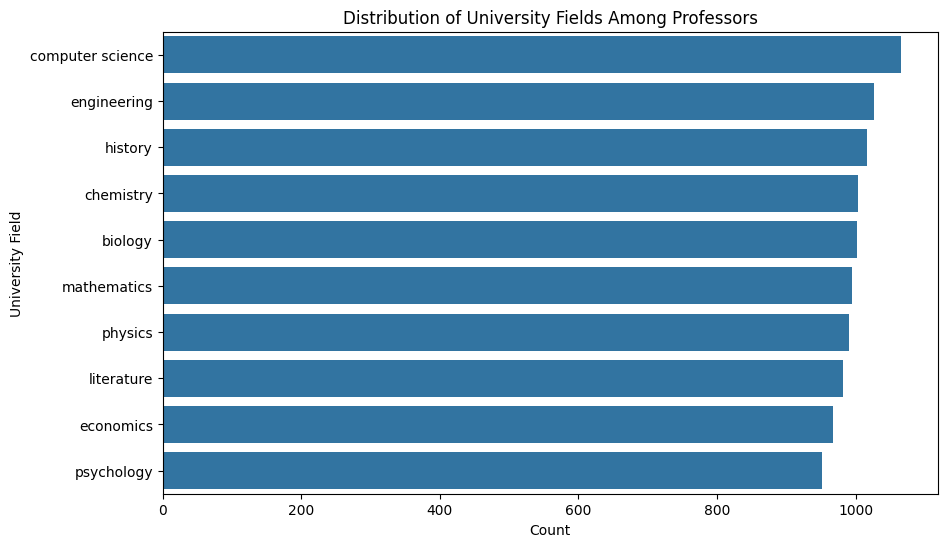

In [11]:
# Distribution of University Field for Professors
plt.figure(figsize=(10, 6))
sns.countplot(y=professors_df['University Field'], order = professors_df['University Field'].value_counts().index)
plt.title('Distribution of University Fields Among Professors')
plt.xlabel('Count')
plt.ylabel('University Field')
plt.show()

In [14]:
# Initialize SBERT model
model = SentenceTransformer('all-mpnet-base-v2')

# Encode research interests for students and professors
students_df['Research Interests'] = students_df['Research Interests'].apply(lambda x: ', '.join(x))
professors_df['Research Interests'] = professors_df['Research Interests'].apply(lambda x: ', '.join(x))
# Encode research interests
students_df['Encoded Interests'] = list(model.encode(students_df['Research Interests'].tolist(), convert_to_tensor=False))
professors_df['Encoded Interests'] = list(model.encode(professors_df['Research Interests'].tolist(), convert_to_tensor=False))


# One-hot encode university fields
encoder = OneHotEncoder()
all_fields = np.concatenate((students_df['University Field'].values, professors_df['University Field'].values), axis=0)
encoder.fit(all_fields.reshape(-1, 1))
student_fields_encoded = encoder.transform(students_df['University Field'].values.reshape(-1, 1)).toarray()
professor_fields_encoded = encoder.transform(professors_df['University Field'].values.reshape(-1, 1)).toarray()

# Combine SBERT embeddings with one-hot encoded fields, applying weights
weights = {'research_interests': 0.8, 'university_field': 0.2}
scaler = StandardScaler()


In [18]:
# Scale research embeddings and apply weights
student_research_scaled = scaler.fit_transform(students_df['Encoded Interests'].tolist()) * weights['research_interests']
professor_research_scaled = scaler.transform(professors_df['Encoded Interests'].tolist()) * weights['research_interests']

# Combine scaled and weighted embeddings with encoded fields
student_combined_features = np.hstack((student_research_scaled, student_fields_encoded * weights['university_field']))
professor_combined_features = np.hstack((professor_research_scaled, professor_fields_encoded * weights['university_field']))

# Calculate cosine similarity between student and professor features
similarity_matrix = cosine_similarity(student_combined_features, professor_combined_features)


In [19]:
#Functions to get top k recommendations for students and professors based on similarity
def get_student_recommendations(similarity_matrix, students_df, professors_df, top_k=5):
    recommendations = {}
    for idx, student in enumerate(students_df['Student GUID']):
        top_indices = np.argsort(-similarity_matrix[idx])[:top_k]
        top_professors = professors_df.iloc[top_indices][['Professor GUID', 'Name']].to_dict(orient='records')
        recommendations[student] = top_professors
    return recommendations


def get_professor_recommendations(similarity_matrix, students_df, professors_df, top_k=5):
    recommendations = {}
    for idx, professor in enumerate(professors_df['Professor GUID']): #transpose the similarity matrix to match professors to students
        top_indices = np.argsort(-similarity_matrix[:, idx])[:top_k]
        top_students = students_df.iloc[top_indices][['Student GUID', 'Name']].to_dict(orient='records')
        recommendations[professor] = top_students
    return recommendations

# Get and display recommendations for students and professors
student_recommendations = get_student_recommendations(similarity_matrix, students_df, professors_df)
professor_recommendations = get_professor_recommendations(similarity_matrix, students_df, professors_df)

# Display recommendations for the first student and first professor
print("First Student Recommendations:", student_recommendations[students_df.iloc[0]['Student GUID']])
print("First Professor Recommendations:", professor_recommendations[professors_df.iloc[0]['Professor GUID']])

First Student Recommendations: [{'Professor GUID': '0747913a-18f4-4124-ad34-9772252d04ee', 'Name': 'kenneth pineda'}, {'Professor GUID': '93e068e0-b3d8-48ee-a9f3-ed5a2859c642', 'Name': 'daniel goodman'}, {'Professor GUID': '6f9bf723-c7b7-4b2c-b582-95e498fa2ad1', 'Name': 'matthew werner'}, {'Professor GUID': 'bebbd27a-8b2d-4893-be75-2e002aaa92a7', 'Name': 'kendra west'}, {'Professor GUID': '71773d34-77c3-4e8b-814a-5c31e97ae81f', 'Name': 'emily rogers'}]
First Professor Recommendations: [{'Student GUID': '45c9e2ec-75b0-4622-8f0d-bc57606b9771', 'Name': 'nicholas allen'}, {'Student GUID': '0a386146-5080-418f-a461-e59f63ac0f7b', 'Name': 'nathan stanley'}, {'Student GUID': 'ca50db49-49c4-4429-8f97-761612c796fd', 'Name': 'mark martin'}, {'Student GUID': '571b57ac-250d-4ffe-a7c1-2fcc0707198e', 'Name': 'michaela aguirre md'}, {'Student GUID': '4f567a50-7775-4040-917d-10f3154c15e9', 'Name': 'jeremy bird'}]


In [20]:
# Function to get recommendations among professors
def get_professor_to_professor_recommendations(professor_combined_features, professors_df, top_k=5):
    # Calculate cosine similarity among professors
    prof_similarity_matrix = cosine_similarity(professor_combined_features)
    recommendations = {}
    for idx, professor in enumerate(professors_df['Professor GUID']):
        top_indices = np.argsort(-prof_similarity_matrix[idx])[1:top_k+1]
        top_professors = professors_df.iloc[top_indices][['Professor GUID', 'Name']].to_dict(orient='records')
        recommendations[professor] = top_professors
    return recommendations

# Function to get recommendations among students
def get_student_to_student_recommendations(student_combined_features, students_df, top_k=5):
    # Calculate cosine similarity among students
    student_similarity_matrix = cosine_similarity(student_combined_features)
    recommendations = {}
    for idx, student in enumerate(students_df['Student GUID']):
        top_indices = np.argsort(-student_similarity_matrix[idx])[1:top_k+1]
        top_students = students_df.iloc[top_indices][['Student GUID', 'Name']].to_dict(orient='records')
        recommendations[student] = top_students
    return recommendations

# Get recommendations among professors
professor_to_professor_recommendations = get_professor_to_professor_recommendations(professor_combined_features, professors_df)

# Get recommendations among students
student_to_student_recommendations = get_student_to_student_recommendations(student_combined_features, students_df)

# Display recommendations for a sample professor and a sample student
sample_professor_guid = professors_df.iloc[0]['Professor GUID']
sample_student_guid = students_df.iloc[0]['Student GUID']
print("Recommendations for Professor to Professor for Sample Professor GUID:", sample_professor_guid)
print(json.dumps(professor_to_professor_recommendations[sample_professor_guid], indent=4))
print("Recommendations for Student to Student for Sample Student GUID:", sample_student_guid)
print(json.dumps(student_to_student_recommendations[sample_student_guid], indent=4))


Recommendations for Professor to Professor for Sample Professor GUID: ee1d5410-3fd8-444e-b847-b6d7b41137fc
[
    {
        "Professor GUID": "3b4bfe57-d127-4407-89dd-452ee696a4cb",
        "Name": "matthew wilson"
    },
    {
        "Professor GUID": "2a13dde1-7dd1-42ad-83f9-55f2b60dd542",
        "Name": "alexander young"
    },
    {
        "Professor GUID": "3e7b3b41-1cf8-4481-9844-cf2fb5bc92f4",
        "Name": "beth miller"
    },
    {
        "Professor GUID": "3e0efee8-dc7e-428d-8e56-6f9a2b984566",
        "Name": "dawn powell"
    },
    {
        "Professor GUID": "959c3e91-514a-49e9-8aa3-9dbffea03d53",
        "Name": "stanley howell"
    }
]
Recommendations for Student to Student for Sample Student GUID: c1c5fc27-048a-4fad-b32a-57b6613f5c6d
[
    {
        "Student GUID": "609d3093-3d4c-4a5a-b726-577c30cba6e7",
        "Name": "dennis maldonado"
    },
    {
        "Student GUID": "3cb51a45-0c08-4a4f-aada-e5f86be80aaa",
        "Name": "laura king"
    },
    {
        